Grundlegende Statistiken:
count    116170.000000
mean          6.463461
std           7.507467
min         -50.000000
25%           2.954000
50%           4.130000
75%           6.919000
max         209.681000
Name: Spotpreis, dtype: float64

Mittelwert der Spotpreise: 6.46 ct/kWh
Median der Spotpreise: 4.13 ct/kWh
Standardabweichung der Spotpreise: 7.51 ct/kWh


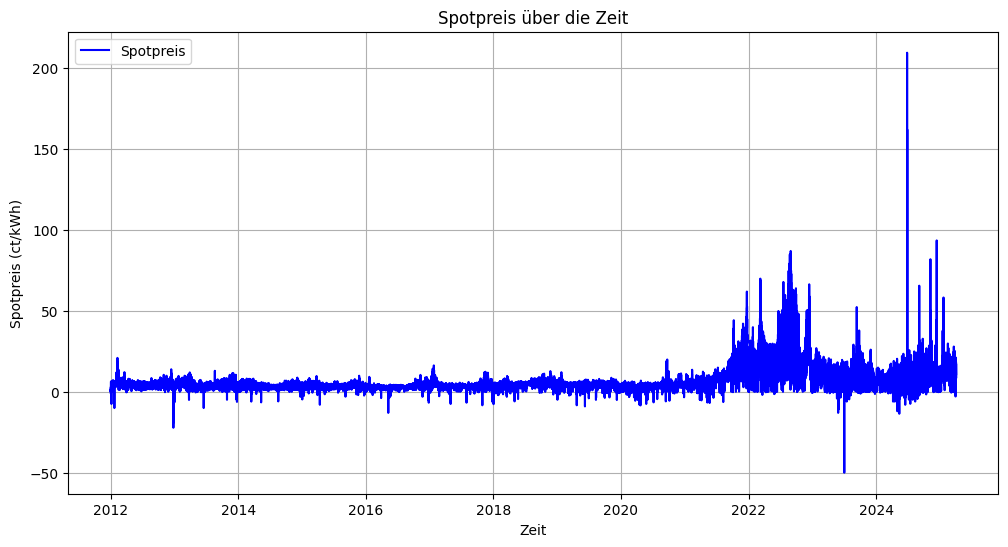

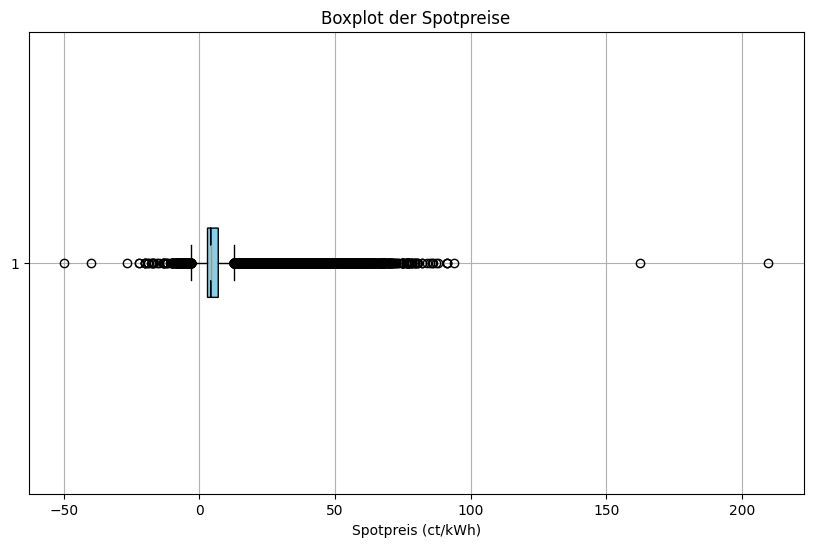

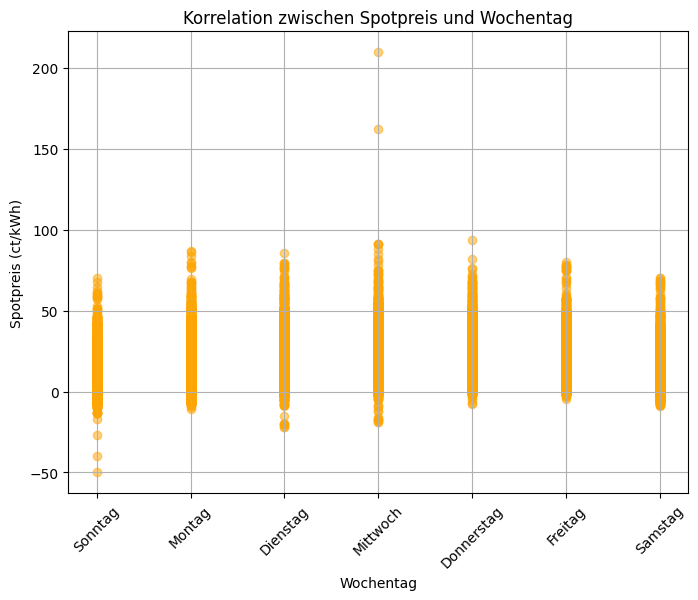

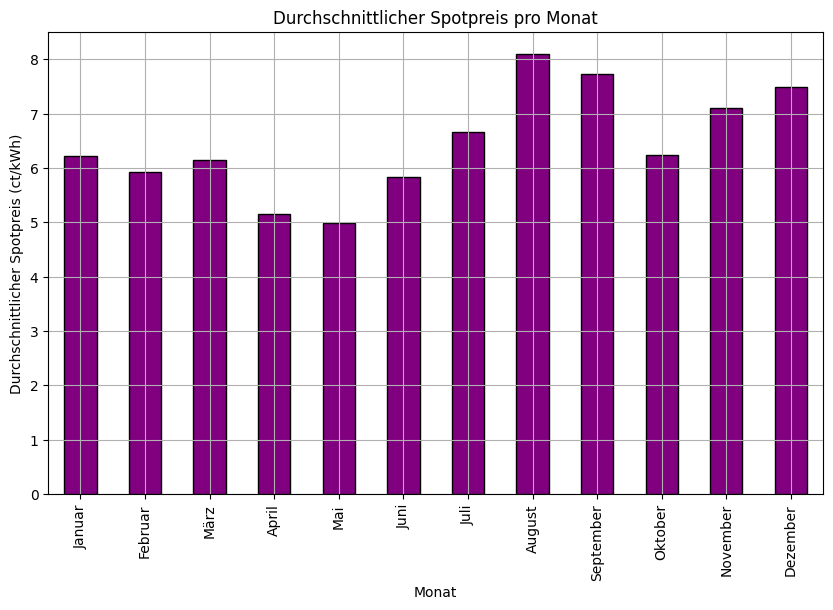

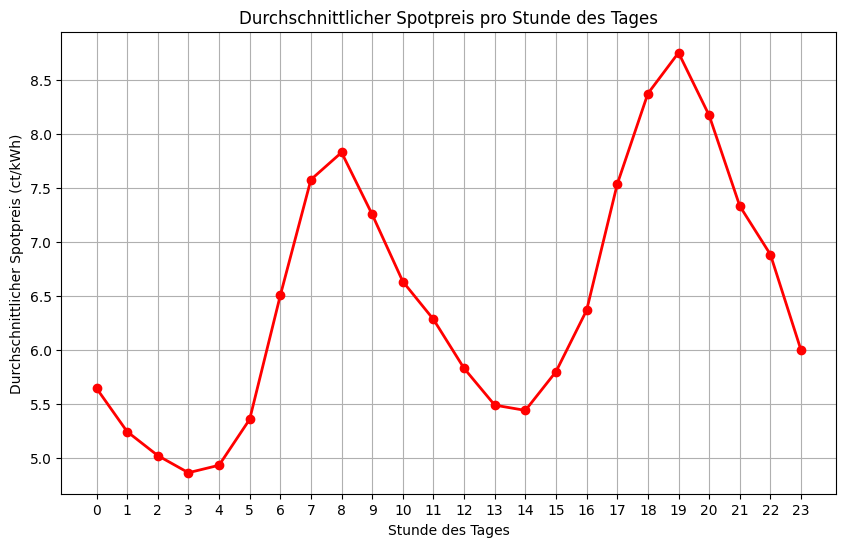

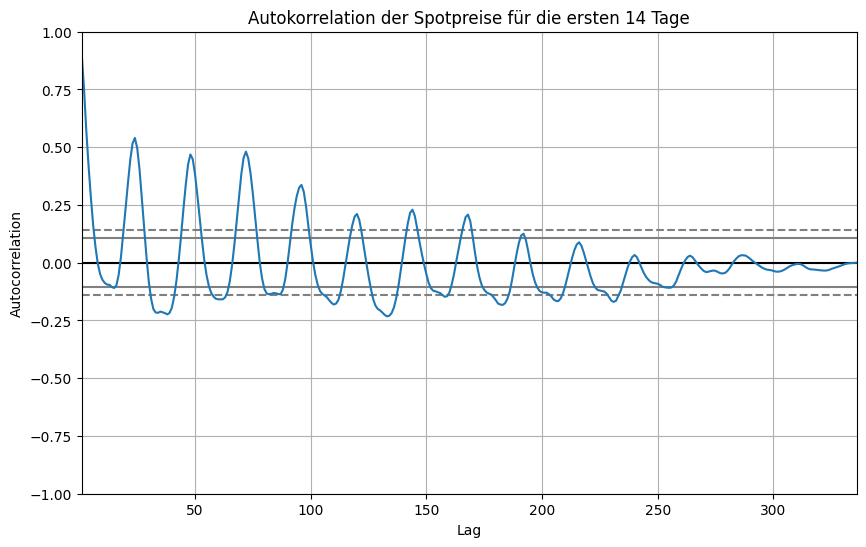

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dateipfad
file_path = "energy_prices_data.csv"  # Stelle sicher, dass der Pfad korrekt ist

# Lade die Daten
df = pd.read_csv(file_path, sep=';', decimal=',', header=0)

# Kombiniere Datum und von für die 'Datetime'-Spalte
df['Datetime'] = pd.to_datetime(df['Datum'] + ' ' + df['von'], format='%d.%m.%Y %H:%M', errors='coerce')

# Entferne Zeilen mit NaT (Fehler bei der Datumsumwandlung)
df.dropna(subset=['Datetime'], inplace=True)

# Wähle die relevanten Spalten und benenne sie um
df = df[['Datetime', 'Spotmarktpreis in ct/kWh']]
df.rename(columns={'Spotmarktpreis in ct/kWh': 'Spotpreis'}, inplace=True)

# Entfernen von Zeilen mit NaN-Werten in der Spotpreis-Spalte
df.dropna(subset=['Spotpreis'], inplace=True)

# Setze 'Datetime' als Index
df.set_index('Datetime', inplace=True)

# Grundlegende statistische Analyse
print("Grundlegende Statistiken:")
print(df['Spotpreis'].describe())

mean_price = df['Spotpreis'].mean()  # Mittelwert
median_price = df['Spotpreis'].median()  # Median
std_dev = df['Spotpreis'].std()  # Standardabweichung

print(f"\nMittelwert der Spotpreise: {mean_price:.2f} ct/kWh")
print(f"Median der Spotpreise: {median_price:.2f} ct/kWh")
print(f"Standardabweichung der Spotpreise: {std_dev:.2f} ct/kWh")

# 1. Visualisierung der Spotpreise über die Zeit
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Spotpreis'], label="Spotpreis", color='blue')
plt.xlabel('Zeit')
plt.ylabel('Spotpreis (ct/kWh)')
plt.title('Spotpreis über die Zeit')
plt.legend()
plt.grid(True)
plt.show()

# 2. Boxplot der Spotpreise
plt.figure(figsize=(10, 6))
plt.boxplot(df['Spotpreis'], vert=False, patch_artist=True, notch=True, boxprops=dict(facecolor='skyblue'))
plt.xlabel('Spotpreis (ct/kWh)')
plt.title('Boxplot der Spotpreise')
plt.grid(True)
plt.show()

# 3. Visualisierung der Korrelation zwischen Spotpreis und Wochentag
df['Wochentag'] = df.index.weekday  # 0 = Montag, 6 = Sonntag

# Ersetze die Wochentagsnummern durch die Namen
wochentag_mapping = {
    0: 'Montag', 1: 'Dienstag', 2: 'Mittwoch', 3: 'Donnerstag', 
    4: 'Freitag', 5: 'Samstag', 6: 'Sonntag'
}
df['Wochentag'] = df['Wochentag'].map(wochentag_mapping)

plt.figure(figsize=(8, 6))
plt.scatter(df['Wochentag'], df['Spotpreis'], alpha=0.5, color='orange')
plt.xlabel('Wochentag')
plt.ylabel('Spotpreis (ct/kWh)')
plt.title('Korrelation zwischen Spotpreis und Wochentag')
plt.grid(True)
plt.xticks(rotation=45)  # Dreht die Wochentagsbezeichnungen
plt.show()

# 4. Saisonale Trends: Durchschnitt pro Monat
df['Monat'] = df.index.month
monthly_avg = df.groupby('Monat')['Spotpreis'].mean()

# Visualisierung des monatlichen Durchschnitts mit Monatsnamen
monthly_avg.index = monthly_avg.index.map({
    1: 'Januar', 2: 'Februar', 3: 'März', 4: 'April', 5: 'Mai', 6: 'Juni',
    7: 'Juli', 8: 'August', 9: 'September', 10: 'Oktober', 11: 'November', 12: 'Dezember'
})

plt.figure(figsize=(10, 6))
monthly_avg.plot(kind='bar', color='purple', edgecolor='black')
plt.xlabel('Monat')
plt.ylabel('Durchschnittlicher Spotpreis (ct/kWh)')
plt.title('Durchschnittlicher Spotpreis pro Monat')
plt.grid(True)
plt.show()

# 5. Durchschnittlicher Spotpreis pro Stunde des Tages
df['Stunde'] = df.index.hour  # Extrahiere die Stunde des Tages

# Berechne den durchschnittlichen Spotpreis pro Stunde
hourly_avg = df.groupby('Stunde')['Spotpreis'].mean()

# Visualisierung des durchschnittlichen Spotpreises pro Stunde des Tages
plt.figure(figsize=(10, 6))
hourly_avg.plot(kind='line', marker='o', color='red', linestyle='-', linewidth=2, markersize=6)
plt.xlabel('Stunde des Tages')
plt.ylabel('Durchschnittlicher Spotpreis (ct/kWh)')
plt.title('Durchschnittlicher Spotpreis pro Stunde des Tages')
plt.grid(True)
plt.xticks(range(0, 24))  # Zeige alle Stunden von 0 bis 23 an
plt.show()

# 6. Autokorrelation der Spotpreise für die ersten 14 Tage (336 Lag)
from pandas.plotting import autocorrelation_plot

# Beschränke die Daten auf die ersten 14 Tage (336 Stunden)
df_14_days = df[:14 * 24]  # 14 Tage * 24 Stunden = 336 Datenpunkte

plt.figure(figsize=(10, 6))
autocorrelation_plot(df_14_days['Spotpreis'])
plt.title('Autokorrelation der Spotpreise für die ersten 14 Tage')
plt.show()


In [2]:
import pandas as pd
file_path = "energy_prices_data.csv"  

df = pd.read_csv(file_path, sep=';', decimal=',', header=0)
df.tail()

,Datum,von,Zeitzone von,bis,Zeitzone bis,Spotmarktpreis in ct/kWh
116166,02.04.2025,19:00,CET,20:00,CET,17.39
116167,02.04.2025,20:00,CET,21:00,CET,15.61
116168,02.04.2025,21:00,CET,22:00,CET,13.20
116169,02.04.2025,22:00,CET,23:00,CET,10.69
116170,02.04.2025,23:00,CET,00:00,CET,9.08


Lade vorhandenes Modell...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Vorhersage für den 2025-04-03:
[[ 7.3341393  6.8678823  7.6936593  8.967259  10.413213  11.981019
  13.747824  13.894572  13.0787325 11.412923   9.485617   8.207891
   7.987157   8.002902   9.090853  10.220839  12.251423  13.770658
  14.990397  15.609471  15.082663  13.803874  11.798349  10.198546 ]]


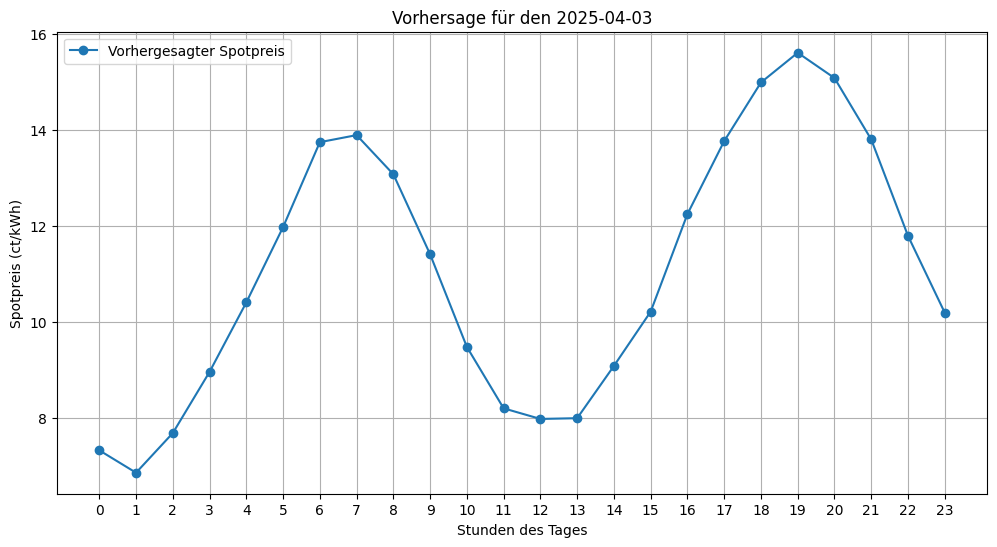

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanSquaredError
from datetime import datetime, timedelta

# Dateipfad
file_path = "energy_prices_data.csv"
model_path = "energy_price_model.h5"  

# Lade die Daten
df = pd.read_csv(file_path, sep=';', decimal=',', header=0)

# Kombiniere Datum und von für die 'Datetime'-Spalte
df['Datetime'] = pd.to_datetime(df['Datum'] + ' ' + df['von'], format='%d.%m.%Y %H:%M', errors='coerce')

# Entferne Zeilen mit NaT (Fehler bei der Datumsumwandlung)
df.dropna(subset=['Datetime'], inplace=True)

# Wähle die relevanten Spalten und benenne sie um
df = df[['Datetime', 'Spotmarktpreis in ct/kWh']]
df.rename(columns={'Spotmarktpreis in ct/kWh': 'Spotpreis'}, inplace=True)

# Entfernen von Zeilen mit NaN-Werten in der Spotpreis-Spalte
df.dropna(subset=['Spotpreis'], inplace=True)

# Setze 'Datetime' als Index
df.set_index('Datetime', inplace=True)

# Normalisiere die Daten
scaler = MinMaxScaler(feature_range=(0, 1))
df['Spotpreis'] = scaler.fit_transform(df[['Spotpreis']])

# Sequenzen erstellen
def create_sequences(data, seq_length=336, output_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length - output_length):
        X.append(data[i:i + seq_length])  # 14 Tage Input
        y.append(data[i + seq_length:i + seq_length + output_length])  # 24 Stunden Output
    return np.array(X), np.array(y)

seq_length = 336  # 14 Tage
output_length = 24  # 24 Stunden Vorhersage

# Konvertiere die Spotpreis-Daten in ein Array
data = df['Spotpreis'].values
X, y = create_sequences(data, seq_length, output_length)

X = X.reshape((X.shape[0], X.shape[1], 1))

# Datenaufteilung (80% Train, 10% Validation, 10% Test)
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Modell laden oder erstellen
if os.path.exists(model_path):
    print("Lade vorhandenes Modell...")
    model = load_model(model_path, custom_objects={'mse': MeanSquaredError()})
    model.compile(optimizer='adam', loss='mse')
else:
    print("Erstelle neues Modell...")
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        LSTM(50),
        Dense(output_length) 
    ])
    model.compile(optimizer='adam', loss='mse')

# Modell trainieren, falls es noch nicht existiert
if not os.path.exists(model_path):  
    model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_val, y_val))
    model.save(model_path)  

# Berechne das Datum für den nächsten Tag
last_date = df.index[-1]
next_day = last_date + timedelta(days=1)

# Vorhersage für den nächsten Tag
latest_data = np.array([data[-seq_length:]])
latest_data = latest_data.reshape((1, seq_length, 1))
predictions = model.predict(latest_data)  

# Transformiere die Vorhersage zurück auf den originalen Preisbereich
predictions = scaler.inverse_transform(predictions)
print(f"Vorhersage für den {next_day.date()}:")
print(predictions)

hours = np.arange(0, output_length)  # 0 bis 23 Stunden

# Plotten der Vorhersage
plt.figure(figsize=(12, 6))
plt.plot(hours, predictions.flatten(), marker='o', linestyle='-', label='Vorhergesagter Spotpreis')
plt.xlabel('Stunden des Tages')
plt.ylabel('Spotpreis (ct/kWh)')
plt.title(f'Vorhersage für den {next_day.date()}')
plt.legend()
plt.grid()
plt.xticks(hours)
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


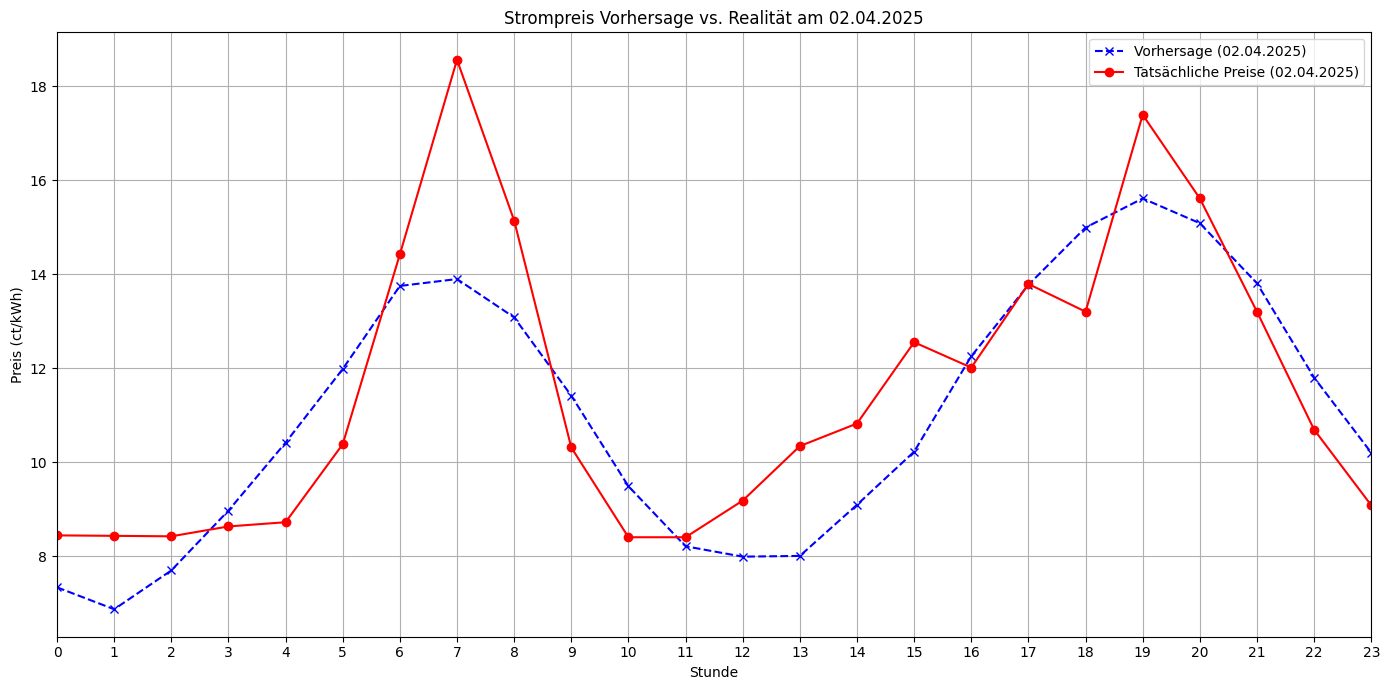

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

# Rückskalierung und Datenvorbereitung
# Die letzten 24 Stunden tatsächlichen Preise des letzten Tages
actual_prices_today = scaler.inverse_transform(df['Spotpreis'][-24:].values.reshape(-1, 1))

# Die letzten 14 Tage für die Vorhersage (entsprechend dem seq_length)
latest_data = np.array([data[-seq_length:]])
latest_data = latest_data.reshape((1, seq_length, 1))

# Vorhersage für die nächsten 24 Stunden (für den letzten Tag)
predictions_today = scaler.inverse_transform(model.predict(latest_data))[0]

# X-Achse von 0 bis 24 Stunden
hours = np.arange(24)

# Aktuelles Datum für den Titel (der letzte Tag in den Daten)
current_day_str = df.index[-1].strftime('%d.%m.%Y')

# Plot mit synchronisierter X-Achse
plt.figure(figsize=(14, 7))

# Plot der Vorhersage
plt.plot(hours, 
         predictions_today, 
         label=f"Vorhersage ({current_day_str})",
         linestyle='--', 
         marker='x',
         color='blue')

# Plot der tatsächlichen Preise des letzten Tages
plt.plot(hours, 
         actual_prices_today, 
         label=f"Tatsächliche Preise ({current_day_str})", 
         linestyle='-', 
         marker='o', 
         color='red')

# Formatierung
plt.title(f"Strompreis Vorhersage vs. Realität am {current_day_str}")
plt.xlabel("Stunde")
plt.ylabel("Preis (ct/kWh)")
plt.xticks(np.arange(0, 25, 3))  # X-Achse in 3-Stunden-Schritten
plt.xlim(0, 23)  # Begrenzung von 0 bis 23 Uhr
plt.grid(True)
plt.legend()

# Feineinteilung der X-Achse auf ganze Stunden
plt.gca().xaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


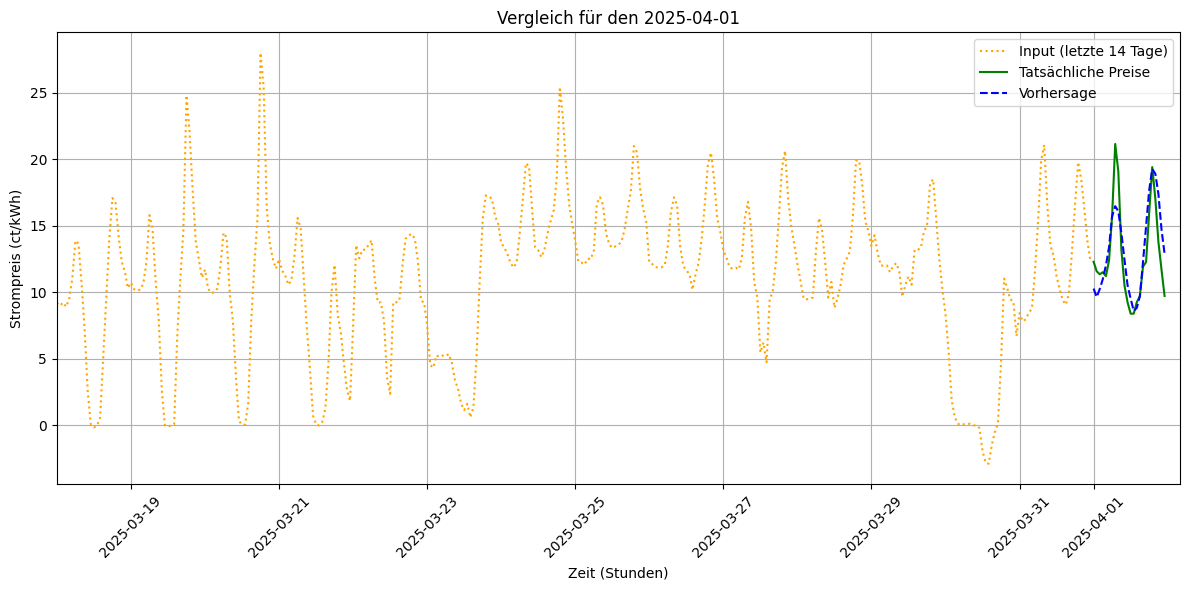

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

# Gewählter Tag und Vorbereitung der Daten
chosen_date = '2025-04-01'
start_date_input = pd.to_datetime(chosen_date) - timedelta(days=14)  # Startdatum 14 Tage vorher

# Tatsächliche Preise des gewählten Tages
actual_prices_day = df.loc[chosen_date].values
actual_prices_day = scaler.inverse_transform(actual_prices_day.reshape(-1, 1))

# Input-Daten (letzte 14 Tage vor chosen_date)
last_14_days_data = data[df.index < chosen_date][-seq_length:]
last_14_days_data = last_14_days_data.reshape((1, seq_length, 1))

# Vorhersage generieren
predictions_day = model.predict(last_14_days_data)
predictions_day = scaler.inverse_transform(predictions_day)

# Korrekte Generierung der Datumsbereiche
input_dates = pd.date_range(start=start_date_input, periods=seq_length, freq='h')  # 14 Tage vor chosen_date
prediction_dates = pd.date_range(start=chosen_date, periods=24, freq='h')         # 24h des gewählten Tages

# Plot
plt.figure(figsize=(12, 6))

# Input-Daten (letzte 14 Tage)
plt.plot(
    input_dates,
    scaler.inverse_transform(last_14_days_data[0].reshape(-1, 1)),
    label="Input (letzte 14 Tage)",
    color='orange',
    linestyle=':'
)

# Tatsächliche Preise und Vorhersage
plt.plot(prediction_dates, actual_prices_day, label="Tatsächliche Preise", color='g')
plt.plot(prediction_dates, predictions_day[0], label="Vorhersage", color='b', linestyle='--')

# Füge rechts noch etwas Platz hinzu, z.B. 2 Stunden
extra_time = timedelta(hours=5) 

# Setze die x-Achsen-Grenzen mit etwas zusätzlichem Platz auf der rechten Seite
plt.xlim([input_dates[0], prediction_dates[-1] + extra_time])


# Achsenbeschriftungen anpassen
plt.xlabel("Zeit (Stunden)")
plt.ylabel("Strompreis (ct/kWh)")
plt.title(f"Vergleich für den {chosen_date}")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


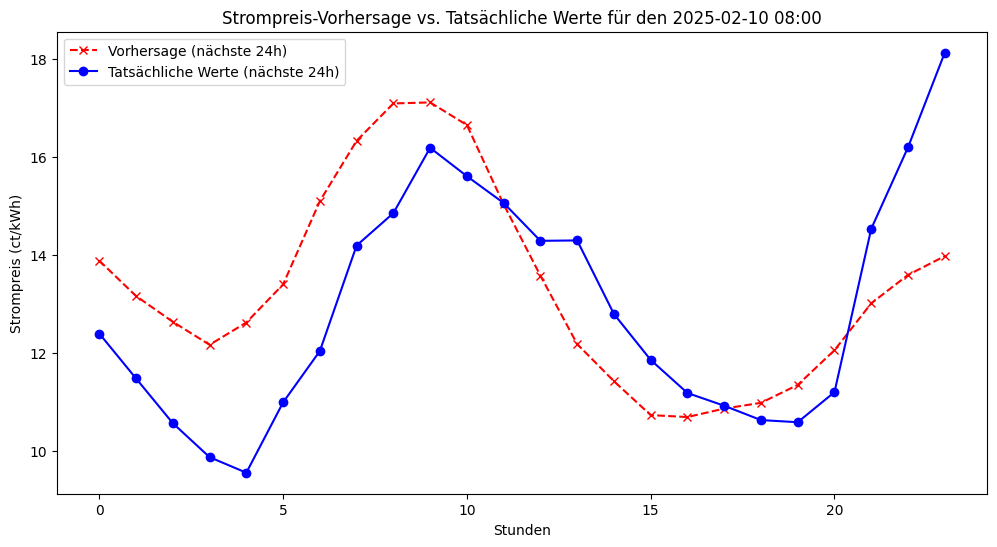

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Holen des Index für die aktuellen 24 Stunden (der letzte Testdatensatz für den heutigen Tag)
today = datetime.now().strftime('%Y-%m-%d')

# Gehe davon aus, dass die Zeitstempel der tatsächlichen Daten mit den Vorhersage-Daten übereinstimmen
today_data = df[df.index.date == datetime.today().date()]  # Aktuelle Daten für heute
today_data = today_data[['Spotpreis']]  # Nur Spotpreise (kWh)

# Wählen eines zufälligen Index im Testdatensatz (der heutigen Stunde)
random_index = np.random.randint(0, len(X_test)) 

# Hole die Eingabedaten und die tatsächlichen Ausgabewerte (y_test) für den zufälligen Index
input_data = X_test[random_index]
true_values = y_test[random_index]

# Mache eine Vorhersage für diesen Index
prediction = model.predict(input_data.reshape(1, seq_length, 1))

# Rücktransformation der Vorhersage und der tatsächlichen Werte
prediction = scaler.inverse_transform(prediction)
true_values = scaler.inverse_transform(true_values.reshape(1, -1))

# Bestimme das Datum für den zufälligen Index
start_date = df.index[-len(X_test)]  # Der Startzeitpunkt für die Testdaten
random_date = start_date + timedelta(hours=random_index)

# Plot der Vorhersage und der tatsächlichen Werte
plt.figure(figsize=(12, 6))

# Plot für die Vorhersage
plt.plot(range(24), prediction[0], label="Vorhersage (nächste 24h)", marker='x', linestyle='--', color='red')

# Plot für die tatsächlichen Werte
plt.plot(range(24), true_values[0], label="Tatsächliche Werte (nächste 24h)", marker='o', linestyle='-', color='blue')

# Achsenbeschriftungen und Titel
plt.xlabel("Stunden")
plt.ylabel("Strompreis (ct/kWh)")
plt.legend()
plt.title(f"Strompreis-Vorhersage vs. Tatsächliche Werte für den {random_date.strftime('%Y-%m-%d %H:%M')}")

# Anzeigen des Plots
plt.show()


In [7]:
from sklearn.metrics import mean_squared_error

# Sequenzen erstellen
def create_sequences(data, seq_length=336, output_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length - output_length):
        X.append(data[i:i + seq_length])  # 14 Tage Input
        y.append(data[i + seq_length:i + seq_length + output_length])  # 24 Stunden Output
    return np.array(X), np.array(y)


seq_length = 336  # 14 Tage
output_length = 24  # 24 Stunden Vorhersage

# Konvertiere die Spotpreis-Daten in ein Array
data = df['Spotpreis'].values
X, y = create_sequences(data, seq_length, output_length)

X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-Test-Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Vorhersage auf dem Testdatensatz
y_pred = model.predict(X_test)

# Rücktransformation der Vorhersagen und echten Werte
y_pred = y_pred.reshape(-1, 1)  # Umformung der Vorhersagen auf 2D (n_samples, n_features)
y_test_inv = y_test.reshape(-1, 1)  # Umformung der echten Werte auf 2D (n_samples, n_features)

# Rückskalierung der Vorhersagen und der echten Werte
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test_inv)

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)

# Ausgabe der Metriken
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


724/724 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step
Mean Squared Error (MSE): 27.349919454433373
Root Mean Squared Error (RMSE): 5.229715045242272
